# 8장 안전 운전자 예측

In [ ]:
# 8장 안전 운전자 예측

# 사고를 낼 가능성이 낮은 안전 운전자에게는 보험료를 적게 청구하고,
# 사고 가능성이 높은 난폭 운전자에게는 많은 보험료를 청구해야합니다.
# 운전자가 보험금을 청구할 확률을 정확히 예측하는 모델을 만드는 게 본 경진대회의 목표입니다.

# 0 : 운전자가 보험금을 청구하지 않는다.
# 1 : 청구한다.

# ⇒ 이진분류 문제

In [1]:
# 라이브러리 불러오기
import pandas as pd

import numpy as np
import missingno as msno

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import math
import lightgbm

In [2]:
# 데이터 불러오기

# 데이터 경로
data_path = "data/"

# train
train = pd.read_csv(data_path + 'train.csv', index_col = 'id')

# test
test = pd.read_csv(data_path + 'test.csv', index_col = 'id')

# sample 결과
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col = 'id')

In [3]:
# 훈련 데이터와 테스트 데이터 크기 확인

print("#1. 데이터 크기 확인")
print("train : ", train.shape) #59만개 - 타겟 데이터 포함
print("test  : ", test.shape) #89만개
print()

# 데이터 index 확인
train.info()
# 피처명
# ps_[분류]_[분류별 일련번호]_[데이터 종류]

#[분류] : ind, reg, car, calc
# [분류별 일련번호] : int..
# [데이터 종류] : bin, cat

#- bin : 이진 피처 (고유 값 2개)
#    - 했는지 안했는지 이산적인 정보
#- cat : 명목형 피처 (순서를 매길 수 없지만, 셀 수 있다, 구분이 가능하다)
#    - 성별, 성공여부, 혈액형 등 단순 분류 정보
#- null : 순서형 피처, 연속형 피처
#    - 순서형 : 개개의 값이 이산적이며 그들 사이에 순서 관계가 존재하는 자료
#    - 연속형 : 연속적인 값을 갖는 데이터 체중 등을 의미

#1. 데이터 크기 확인
train :  (595212, 58)
test  :  (892816, 57)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 595212 entries, 7 to 1488027
Data columns (total 58 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   target          595212 non-null  int64  
 1   ps_ind_01       595212 non-null  int64  
 2   ps_ind_02_cat   595212 non-null  int64  
 3   ps_ind_03       595212 non-null  int64  
 4   ps_ind_04_cat   595212 non-null  int64  
 5   ps_ind_05_cat   595212 non-null  int64  
 6   ps_ind_06_bin   595212 non-null  int64  
 7   ps_ind_07_bin   595212 non-null  int64  
 8   ps_ind_08_bin   595212 non-null  int64  
 9   ps_ind_09_bin   595212 non-null  int64  
 10  ps_ind_10_bin   595212 non-null  int64  
 11  ps_ind_11_bin   595212 non-null  int64  
 12  ps_ind_12_bin   595212 non-null  int64  
 13  ps_ind_13_bin   595212 non-null  int64  
 14  ps_ind_14       595212 non-null  int64  
 15  ps_ind_15       595212 non-null  int64  
 

In [4]:
# 데이터 형식 첫 5번째 행 추출
print("#3. 데이터 확인")
#train.head()
train['target']
# 0 : 운전자가 보험금을 청구하지 않는다.
# 1 : 청구한다.

#3. 데이터 확인


id
7          0
9          0
13         0
16         0
17         0
          ..
1488013    0
1488016    0
1488017    0
1488021    0
1488027    0
Name: target, Length: 595212, dtype: int64

In [5]:
test.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
0,0,1,8,1,0,0,1,0,0,0,...,1,1,1,12,0,1,1,0,0,1
1,4,2,5,1,0,0,0,0,1,0,...,2,0,3,10,0,0,1,1,0,1
2,5,1,3,0,0,0,0,0,1,0,...,4,0,2,4,0,0,0,0,0,0
3,0,1,6,0,0,1,0,0,0,0,...,5,1,0,5,1,0,1,0,0,0
4,5,1,7,0,0,0,0,0,1,0,...,4,0,0,4,0,1,1,0,0,1


In [6]:
submission.head()

# 타겟값이 1일 확률

# 타겟값이 1일 경우 : 청구하는 경우
# 타겟값이 0일 경우 : 운전자가 보험금을 청구하지 않는 경우

,target
id,
0,0.0364
1,0.0364
2,0.0364
3,0.0364
4,0.0364


In [7]:
# 피처 요약표
def resumetable(df):
    print(f'데이터셋 형상: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])
    summary = summary.rename(columns={'index' : "피처"})
    summary['결측값 개수_before'] = df.isnull().sum().values # 피처별 -1 개수
    summary['결측값 개수_after'] = (df == -1).sum().values # 피처별 -1 개수
    summary['고유값 개수'] = df.nunique().values
    summary['데이터 종류'] = None
    for col in df.columns:
        if 'bin' in col or col == 'target':
            summary.loc[col, '데이터 종류'] = '이진형'
        elif 'cat' in col:
            summary.loc[col, '데이터 종류'] = '명목형'
        elif df[col].dtype == float:
            summary.loc[col, '데이터 종류'] = '연속형'
        elif df[col].dtype == int:
            summary.loc[col, '데이터 종류'] = '순서형'
     
    return summary

In [8]:
summary = resumetable(train)

데이터셋 형상: (595212, 58)


In [9]:
# 값이 누락된 곳에 -1이 입력되어 있으므로 결측값이 없다고 판단함. -> 결측값을 NaN으로 변경
train_copy = train.copy().replace(-1, np.NaN)

<AxesSubplot: >

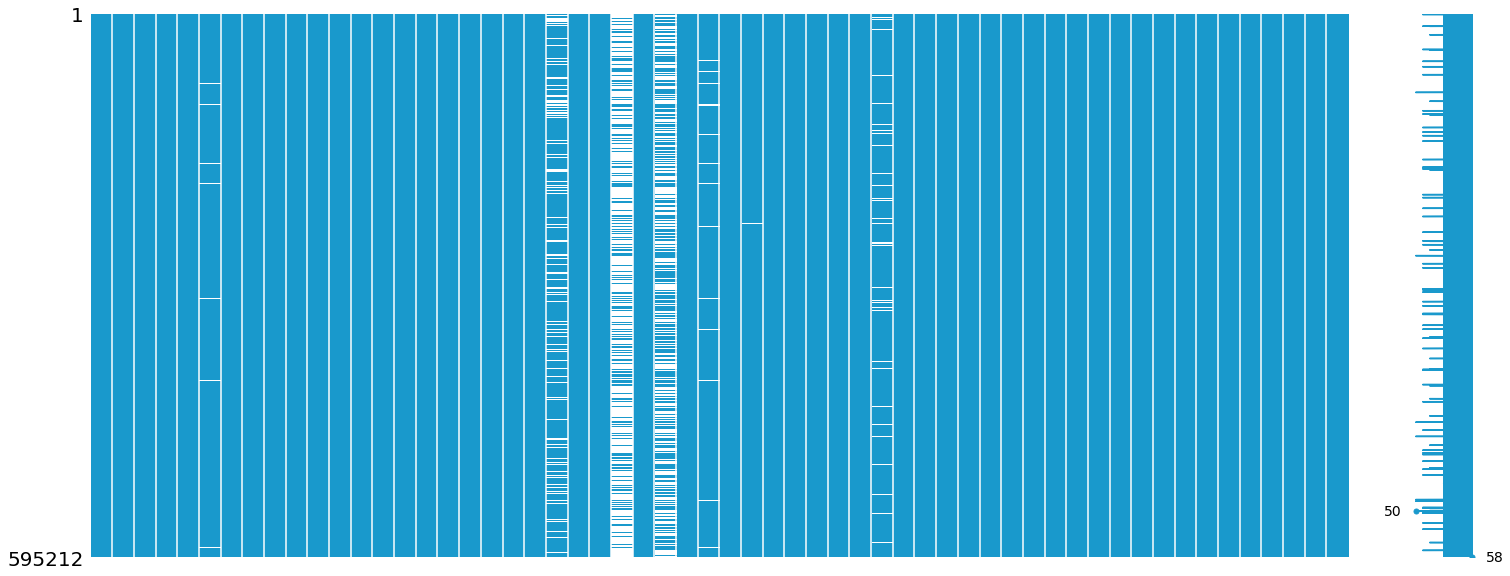

In [10]:
msno.matrix(df=train_copy.iloc[:, :], color=(0.1, 0.6, 0.8))

<AxesSubplot: >

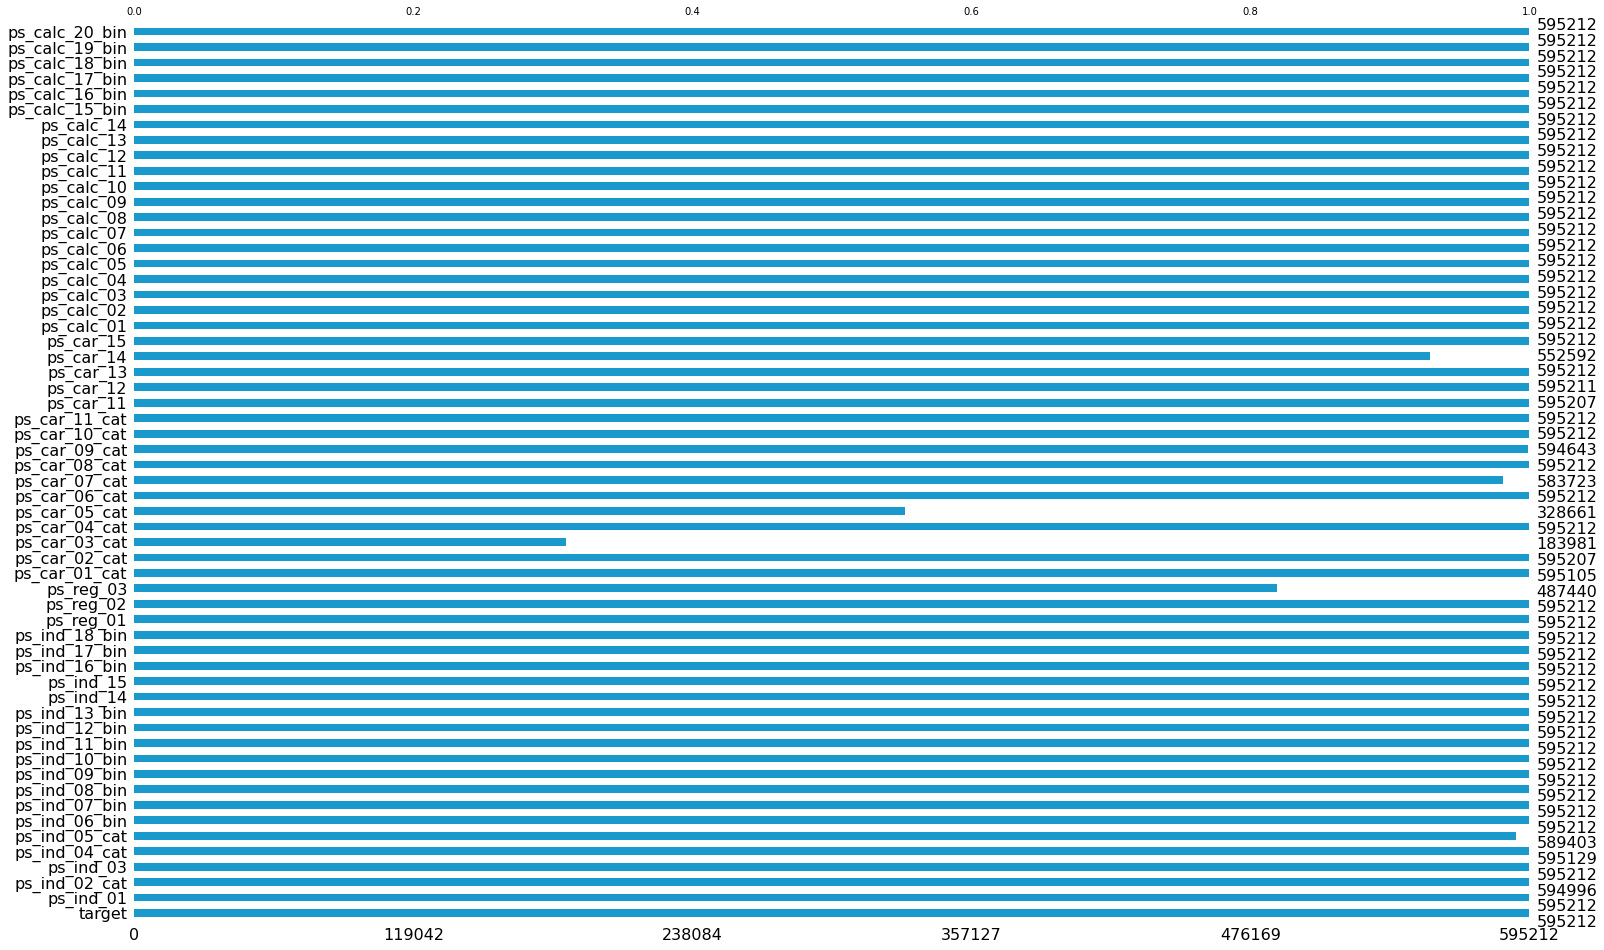

In [11]:
# 결측값 시각화(처음 28개만)
msno.bar(df=train_copy.iloc[:, :], color=(0.1, 0.6, 0.8))

ps_car_12             1
ps_car_02_cat         5
ps_car_11             5
ps_ind_04_cat        83
ps_car_01_cat       107
ps_ind_02_cat       216
ps_car_09_cat       569
ps_ind_05_cat      5809
ps_car_07_cat     11489
ps_car_14         42620
ps_reg_03        107772
ps_car_05_cat    266551
ps_car_03_cat    411231
dtype: int64

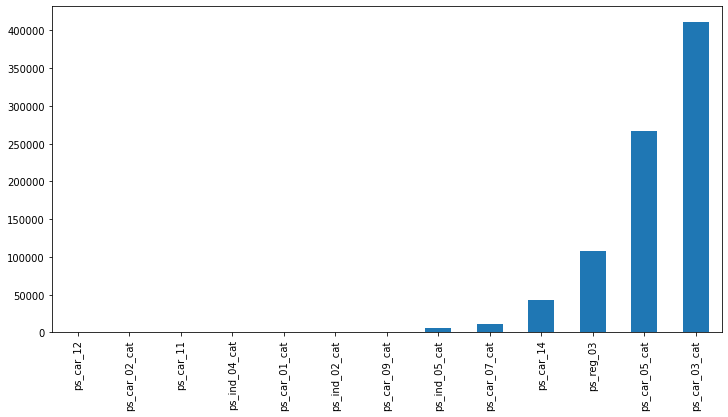

In [12]:
def show_missing(df):
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    missing.sort_values(inplace=True)
    missing.plot.bar(figsize = (12,6))

    return missing

show_missing(train_copy)

In [13]:
# 데이터 시각화
# 모델링에 필요한 피처는 무엇이고, 필요 없는 피처는 무엇인지 선별하는 과정

# - 교윳값별 타깃값 비율을 통해 피처 구분.    
#    타깃값이 불균형 → 비율이 작은 타깃값 1을 잘 예측하는게 중요.   
#    - 타깃값의 비율 차이가 크면 비율이 작은 타깃값을 잘 예측하는게 중요함.

# 고윳값 별로 타깃값 1 비율이 얼마나 되는지 살펴본다.
# → 타깃값 비율이 똑같거나 통계적 유효성이 떨어지면 도움이 안되는 피처임.
# → 고윳값에 따라 타깃값 비율이 달라야 예측이 도움이 됨.

Text(0.5, 1.0, 'Target Distribution')

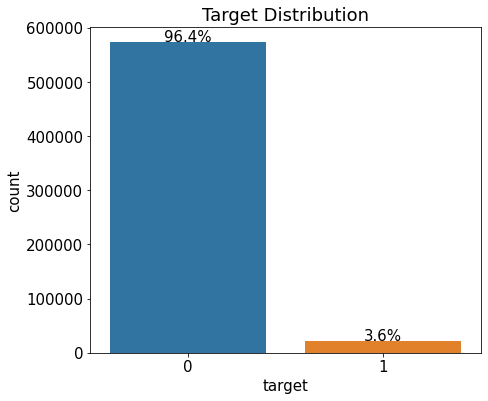

In [14]:
def write_percent(ax, total_size):
    '''도형 객체를 순회하며 막대 그래프 상단에 타깃값 비율 표시'''
    
    for patch in ax.patches:
        # 도형 높이(데이터 개수)
        height = patch.get_height()
        
        # 도형 너비(고유값 개수)
        width = patch.get_width()
        
        # 도형 왼쪽 테두리의 x축 위치
        left_coord = patch.get_x()
        
        # 타깃값 비율
        percent = height/total_size*100
        
        # (x, y) 좌표에 텍스트 입력
        ax.text(left_coord + width/2.0, # x축 위치
               height + total_size*0.001, # y축 위치
               '{:1.1f}%'.format(percent), # 입력 텍스트
               ha = 'center') # 가운데 정렬

mpl.rc('font', size=15)
plt.figure(figsize=(7,6))

ax = sns.countplot(x='target', data=train) 
write_percent(ax, len(train)) # 비율표시
ax.set_title("Target Distribution")

In [15]:
# 이진피처
# 이진피처의 고윳값 별 타깃값의 비율
import matplotlib.gridspec as gridspec

def plot_target_ratio_by_features(df, features, num_rows, num_cols, size=(12, 18)):
    ret = []
    
    mpl.rc('font', size=9)
    plt.figure(figsize=size) #전체 Figure 크기 설정
    grid = gridspec.GridSpec(num_rows, num_cols) # 서브플롯 배치
    plt.subplots_adjust(wspace=0.3, hspace=0.3) # 서브플롯 좌우/상하 여백 설정
    
    for idx, feature in enumerate(features):
        ax = plt.subplot(grid[idx])

        # ax축에 고윳값 별 타깃값 1비율을 막대 그래프로 그리기
        result = sns.barplot(x=feature, y='target', data=df, palette='Set2', ax=ax)
        ret.append(get_target_ci(result, feature))
        
    return ret

In [16]:
def get_target_ci(ax, feature):
    target = []
    error = []
    for line in ax.lines:
        ((x0, x1), (y0, y1)) = line.get_data()
        tmp = y1-y0
        if not math.isnan(tmp):
            error.append(tmp)
        
    for rect in ax.patches:
        ((x0, y0), (x1, y1)) = rect.get_bbox().get_points()
        tmp = y1-y0
        target.append(tmp)
    
    diff_target = max(target) - min(target)
    max_error = max(error)
    return {'feature' : feature, 'target' : target, 'diff_target' : diff_target, 'error' : error, 'max_error' : max_error}

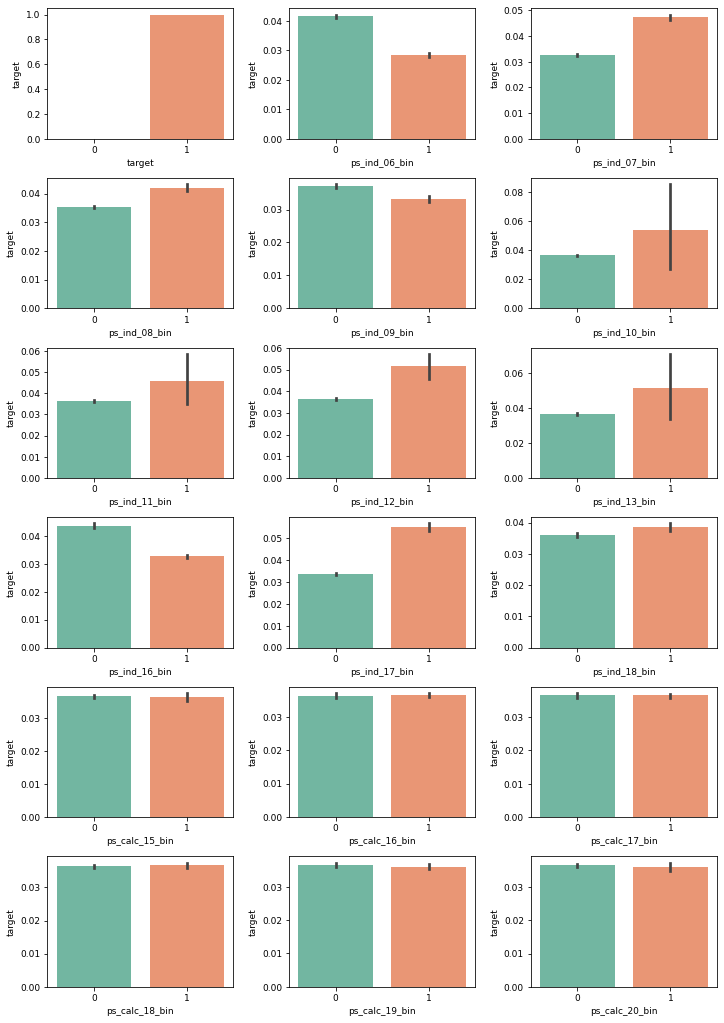

In [17]:
# 피치 요약표에서 원하는 피처를 추출
bin_features = summary[summary['데이터 종류'] == '이진형'].index # 이진 피처

# 이진 피처 고윳값별 타깃값 1 비율을 막대 그래프로 그리기
ret = plot_target_ratio_by_features(train, bin_features, 6, 3) # 6행 3열 배치

# 통계적 유효성 : barplot()을 그릴때 나타나는 신뢰구간으로 판단한다.
# (신뢰구간이 좁아야 모델링에 도움이 된다.)
# → 신뢰구간이 좁다면 통계적으로 유효함.
# → 넓으면 통계적으로 유효하지 않음.

# 모집단 → 임의의 표본(sample)
#우리가 임의로 선정한 표본의 평균(오른쪽 분포에서 빨간색)이 특별한 의미를 가지는 것인가
# 신뢰구간 : 모수(모집단)가 실제로 포함될 것으로 예측되는 범위
# 신뢰구간은 샘플링된 표본이 모집단을 얼마나 잘 대표하는지 측정하는 것.

# 정리 : 유용한 피처 조건
# 1. 고윳값별 타깃값 1 비율이 충분히 차이가 난다.
# 2. 신뢰구간이 작다.    
#    → 해석: 이 데이터를 기반으로, 유사한 100가지의 케이스에서 95개 이상은 해당 범위에서 결과를 얻음을 의미    
#    → ci는 n_boot 만큼 값을 샘플링 했을 때 95%로 해당 검은색 막대에 값이 있다.   
#    - 막대가 길다 = 95%에 해당하는 데이터가 중구난방하게 퍼저있다. = 좋은 분류 척도가 아니다


In [18]:
# 교유값 비율 차이 적은 순
print("#1. 타깃값 비율 적은 순")
ret = sorted(ret, key=lambda x : x['diff_target'])
for feature in ret:
    print('feature : {0}, diff : {1:.6f}'.format(feature['feature'], feature['diff_target']))
print()

# 신뢰구간이 넓은 순
print("#2. 넓은 신뢰구간 순")
ret = sorted(ret, key=lambda x : -x['max_error'])

for feature in ret:
    print('feature : {0}, ci : {1:.6f}'.format(feature['feature'], feature['max_error']))


#1. 타깃값 비율 적은 순
feature : ps_calc_17_bin, diff : 0.000064
feature : ps_calc_18_bin, diff : 0.000229
feature : ps_calc_16_bin, diff : 0.000242
feature : ps_calc_15_bin, diff : 0.000280
feature : ps_calc_20_bin, diff : 0.000558
feature : ps_calc_19_bin, diff : 0.000686
feature : ps_ind_18_bin, diff : 0.002369
feature : ps_ind_09_bin, diff : 0.003973
feature : ps_ind_08_bin, diff : 0.006655
feature : ps_ind_11_bin, diff : 0.009248
feature : ps_ind_16_bin, diff : 0.010996
feature : ps_ind_06_bin, diff : 0.013048
feature : ps_ind_07_bin, diff : 0.014674
feature : ps_ind_13_bin, diff : 0.014985
feature : ps_ind_12_bin, diff : 0.015137
feature : ps_ind_10_bin, diff : 0.017613
feature : ps_ind_17_bin, diff : 0.021285
feature : target, diff : 1.000000

#2. 넓은 신뢰구간 순
feature : ps_ind_10_bin, ci : 0.058671
feature : ps_ind_13_bin, ci : 0.037234
feature : ps_ind_11_bin, ci : 0.023858
feature : ps_ind_12_bin, ci : 0.011570
feature : ps_ind_17_bin, ci : 0.003400
feature : ps_calc_15_bin, ci : 0.0025

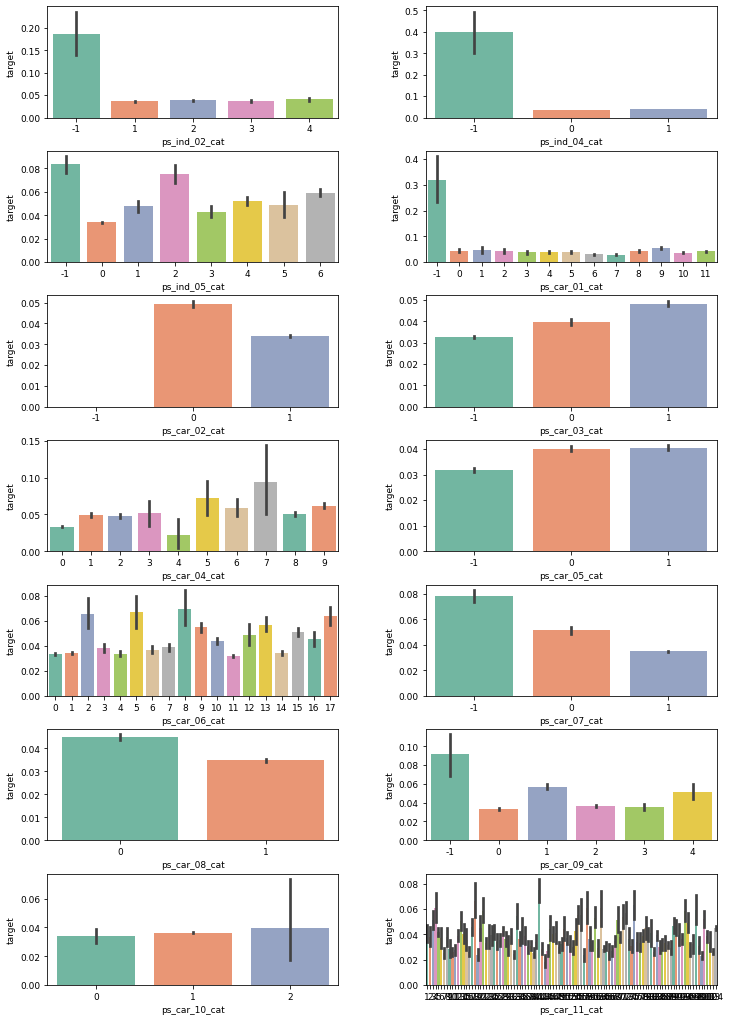

In [62]:
# 명목형 피처

# 피치 요약표에서 원하는 피처를 추출
nom_features = summary[summary['데이터 종류'] == '명목형'].index # 명목형 피처
ret = plot_target_ratio_by_features(train, nom_features, 7, 2) # 7행 2열

In [63]:
# 교유값 비율 차이 적은 순
print("#1. 타깃값 비율 적은 순")
ret = sorted(ret, key=lambda x : x['diff_target'])
for feature in ret:
    print('feature : {0}, diff : {1:.6f}'.format(feature['feature'], feature['diff_target']))
print()

# 신뢰구간이 넓은 순
print("#2. 넓은 신뢰구간 순")
ret = sorted(ret, key=lambda x : -x['max_error'])

for feature in ret:
    print('feature : {0}, ci : {1:.6f}'.format(feature['feature'], feature['max_error']))

#1. 타깃값 비율 적은 순
feature : ps_car_10_cat, diff : 0.005389
feature : ps_car_05_cat, diff : 0.008745
feature : ps_car_08_cat, diff : 0.010198
feature : ps_car_03_cat, diff : 0.015591
feature : ps_car_06_cat, diff : 0.037685
feature : ps_car_07_cat, diff : 0.043395
feature : ps_ind_05_cat, diff : 0.049454
feature : ps_car_02_cat, diff : 0.049507
feature : ps_car_11_cat, diff : 0.056687
feature : ps_car_09_cat, diff : 0.058044
feature : ps_car_04_cat, diff : 0.071786
feature : ps_ind_02_cat, diff : 0.149461
feature : ps_car_01_cat, diff : 0.288987
feature : ps_ind_04_cat, diff : 0.362800

#2. 넓은 신뢰구간 순
feature : ps_ind_04_cat, ci : 0.193072
feature : ps_car_01_cat, ci : 0.177804
feature : ps_ind_02_cat, ci : 0.097222
feature : ps_car_04_cat, ci : 0.093525
feature : ps_car_10_cat, ci : 0.056818
feature : ps_car_09_cat, ci : 0.043981
feature : ps_car_06_cat, ci : 0.028329
feature : ps_car_11_cat, ci : 0.028105
feature : ps_ind_05_cat, ci : 0.021225
feature : ps_car_07_cat, ci : 0.009666
featu

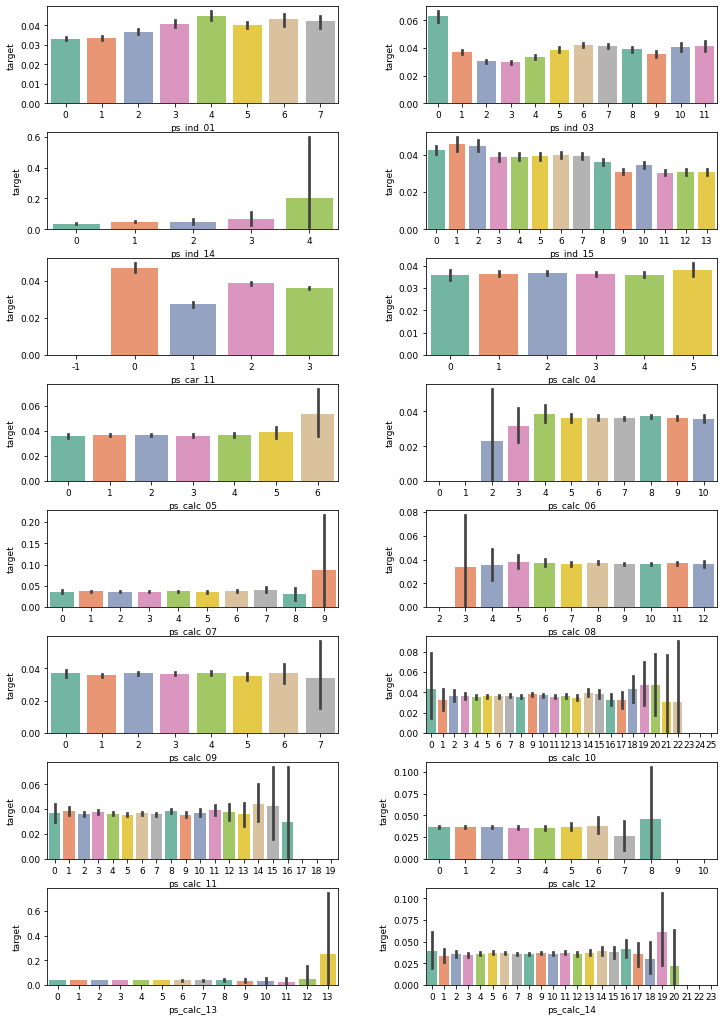

In [20]:
# 순서형 피처

# 피치 요약표에서 원하는 피처를 추출
ord_features = summary[summary['데이터 종류'] == '순서형'].index # 순서형 피처
ret = plot_target_ratio_by_features(train, ord_features, 8, 2) # 8행 2열

In [21]:
# 교유값 비율 차이 적은 순
print("#1. 타깃값 비율 적은 순")
ret = sorted(ret, key=lambda x : x['diff_target'])
for feature in ret:
    print('feature : {0}, diff : {1:.6f}'.format(feature['feature'], feature['diff_target']))
print()

# 신뢰구간이 넓은 순
print("#2. 넓은 신뢰구간 순")
ret = sorted(ret, key=lambda x : -x['max_error'])

for feature in ret:
    print('feature : {0}, ci : {1:.6f}'.format(feature['feature'], feature['max_error']))


#1. 타깃값 비율 적은 순
feature : ps_calc_04, diff : 0.002361
feature : ps_calc_09, diff : 0.002831
feature : ps_ind_01, diff : 0.011911
feature : ps_ind_15, diff : 0.015573
feature : ps_calc_05, diff : 0.017754
feature : ps_ind_03, diff : 0.033288
feature : ps_calc_08, diff : 0.038040
feature : ps_calc_06, diff : 0.038330
feature : ps_calc_11, diff : 0.044374
feature : ps_calc_12, diff : 0.045455
feature : ps_car_11, diff : 0.047069
feature : ps_calc_10, diff : 0.047619
feature : ps_calc_07, diff : 0.055878
feature : ps_calc_14, diff : 0.061069
feature : ps_ind_14, diff : 0.163699
feature : ps_calc_13, diff : 0.227273

#2. 넓은 신뢰구간 순
feature : ps_calc_13, ci : 0.750000
feature : ps_ind_14, ci : 0.600000
feature : ps_calc_07, ci : 0.217391
feature : ps_calc_12, ci : 0.106061
feature : ps_calc_10, ci : 0.090909
feature : ps_calc_14, ci : 0.083969
feature : ps_calc_08, ci : 0.077778
feature : ps_calc_11, ci : 0.073529
feature : ps_calc_06, ci : 0.053030
feature : ps_calc_09, ci : 0.041825
feature

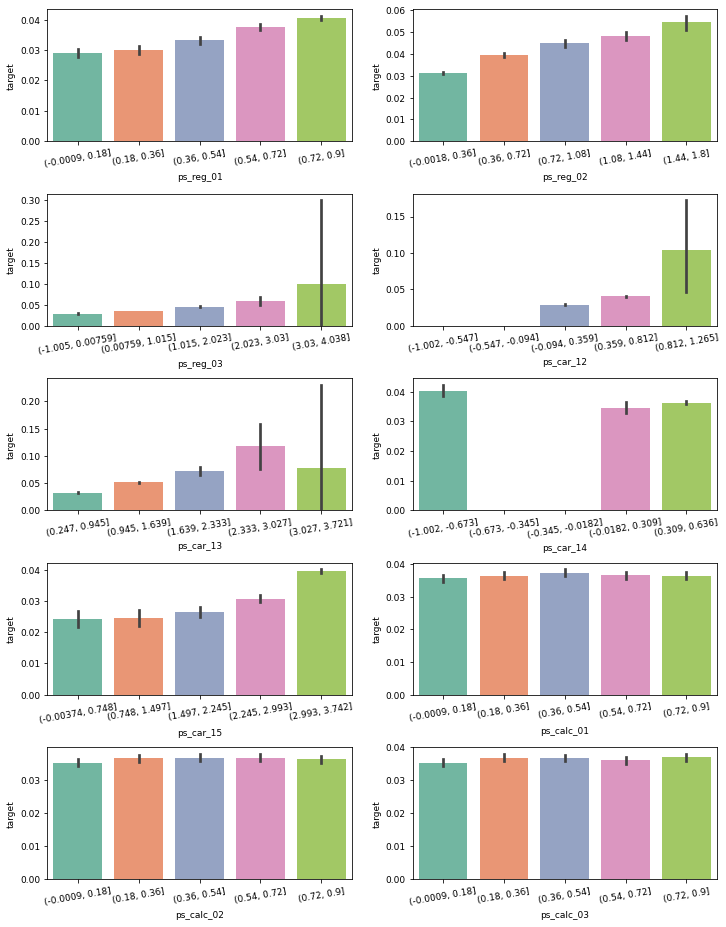

In [22]:
cont_features = summary[summary['데이터 종류'] == '연속형'].index # 연속형 피처
ret = []

plt.figure(figsize=(12, 16))                # Figure 크기 설정
grid = gridspec.GridSpec(5, 2)              # GridSpec 객체 생성
plt.subplots_adjust(wspace=0.2, hspace=0.4) # 서브플롯 간 여백 설정

for idx, cont_feature in enumerate(cont_features):
    # 값을 5개 구간으로 나누기
    train[cont_feature] = pd.cut(train[cont_feature], 5)

    ax = plt.subplot(grid[idx])                # 분포도를 그릴 서브플롯 설정
    result = sns.barplot(x=cont_feature, y='target', data=train, palette='Set2', ax=ax)
    ax.tick_params(axis='x', labelrotation=10) # x축 라벨 회전
    ret.append(get_target_ci(result, cont_feature))

In [23]:
# 교유값 비율 차이 적은 순
print("#1. 타깃값 비율 적은 순")
ret = sorted(ret, key=lambda x : x['diff_target'])
for feature in ret:
    print('feature : {0}, diff : {1:.6f}'.format(feature['feature'], feature['diff_target']))
print()

# 신뢰구간이 넓은 순
print("#2. 넓은 신뢰구간 순")
ret = sorted(ret, key=lambda x : -x['max_error'])

for feature in ret:
    print('feature : {0}, ci : {1:.6f}'.format(feature['feature'], feature['max_error']))


#1. 타깃값 비율 적은 순
feature : ps_calc_02, diff : 0.001512
feature : ps_calc_03, diff : 0.001649
feature : ps_calc_01, diff : 0.001751
feature : ps_car_14, diff : 0.005820
feature : ps_reg_01, diff : 0.011545
feature : ps_car_15, diff : 0.015455
feature : ps_reg_02, diff : 0.023218
feature : ps_reg_03, diff : 0.071607
feature : ps_car_13, diff : 0.086605
feature : ps_car_12, diff : 0.103448

#2. 넓은 신뢰구간 순
feature : ps_reg_03, ci : 0.300000
feature : ps_car_13, ci : 0.230769
feature : ps_car_12, ci : 0.126437
feature : ps_reg_02, ci : 0.006389
feature : ps_car_15, ci : 0.005296
feature : ps_car_14, ci : 0.003942
feature : ps_reg_01, ci : 0.002661
feature : ps_calc_02, ci : 0.002227
feature : ps_calc_01, ci : 0.002163
feature : ps_calc_03, ci : 0.002127


In [ ]:
# 결론 : calc 분류의 피처는 데이터 종류에 상관없이 모두 제거해야한다.

In [24]:
# 연속형 피처 2
# 일반적으로 강한 상관관계를 보이는 두 피처가 있으면 둘 중 하나를 제거하는게 좋습니다.
# → 굳이 피처를 하나 더 써서 예측도를 낮출필요가 없기 떄문.

In [25]:
# 결측값이 있으면 상관관계를 올바르게 구하지 못하므로 결측값을 제거해야함.
train_copy = train_copy.dropna() # -1 -> NaN -> np.NaN값 삭제

<AxesSubplot: >

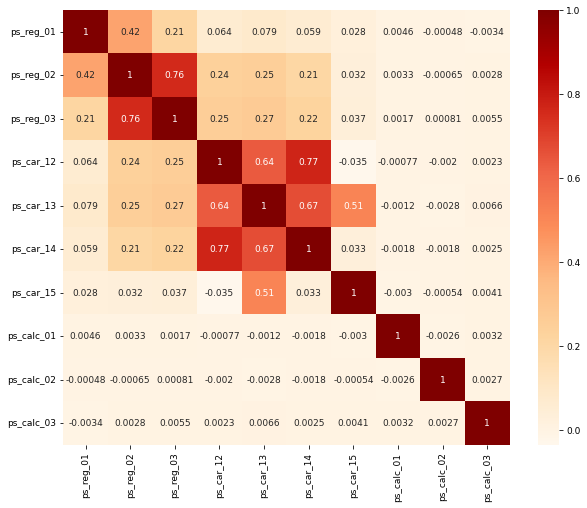

In [26]:
# 상관관계 히트맵
plt.figure(figsize=(10, 8))
cont_corr = train_copy[cont_features].corr() # 연속형 피치 간 상관관계
sns.heatmap(cont_corr, annot=True, cmap='OrRd') # 히트맵 그리기 (OrRd : 그래프 색상맵)

In [27]:
#1. 상관관계 : ps_car_12, ps_car_14 : 0.77
# -> 강한 상관관계 0.8 이상은 아니지만 성능 향상을 위해 제거함.

#2. 상관관계 : ps_reg_02, ps_reg_03 : 0.76
# -> 강한 상관관계 0.8 이상은 아니지만 성능이 높음에도 불구하고 제거 안함.

In [59]:
# 모델링 전략
# 고급 모델링 기법 : OOF 예측, 베이지안 최적화, LightGBM, XGBoost 앙상블

# 1. BaseLine : LightGBM, 마이크로소프트 ~ XGBoost와 함계 캐글에서 가장 많이 사용하는 머신러닝 모델
# 훈련과 예측 과정이 동시에 이루어진다.

# 데이터 불러오기

# train
train = pd.read_csv(data_path + 'train.csv', index_col = 'id')

# test
test = pd.read_csv(data_path + 'test.csv', index_col = 'id')

# sample 결과
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col = 'id')

In [29]:
# 피처 엔지니어링
# 머신 러닝 알고리즘의 성능을 향상하기 위해 데이터를 변환하고 개선하는 프로세스

# 데이터 합치기 : 두 데이터를 동일한 인코딩을 적용하기 위함.
all_data = pd.concat([train, test], ignore_index = True) # 기존 인덱스를 무시하며 train, test 합침.
all_data = all_data.drop('target', axis = 1) # 타겟값 제거, 레이블 축 : 세로 이므로 1.

# 피처만 떼어놓기
all_features = all_data.columns

In [30]:
all_features

Index(['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01',
       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin'],
      dtype='obj

In [31]:
# 명목형 피처 원-핫 인코딩
# 고윳값별 순서가 없기 때문에 적용가능.
# 복잡한 데이터를 그대로 사용하지 않고 컴퓨터가 처리하기 쉽게 숫자로 변형해 줌.
# 범주형 데이터가 순서나 크기의 의미를 포함하고 있을 때 원핫 인코딩을 하게되면 
# 이러한 정보들은 사용할 수 없게된다는 것입니다. 
# 예를 들면 월요일, 화요일, 수요일, 목요일, 금요일, 토요일, 일요일을 원핫 인코딩하면 
# 그저 0과 1일 집합으로 표현됩니다. 
# e.g. 월요일은 [1,0,0,0,0,0,0], 토요일은 [0,0,0,0,0,1,0], 일요일은 [0,0,0,0,0,0,1] 이렇게 되겠지요. 
# 이렇게 인코딩된 값들은 요일간에 순서나 크기를 표현하지 못합니다.

from sklearn.preprocessing import OneHotEncoder

# 명목형 피처 추출
cat_features = [feature for feature in all_features if 'cat' in feature] # cat이 포함된 feature만 뽑아냄.

onehot_encoder = OneHotEncoder() # 원-핫 인코더 객체 생성

# 인코딩
encoded_cat_matrix = onehot_encoder.fit_transform(all_data[cat_features])

In [32]:
encoded_cat_matrix.shape

(1488028, 184)

In [33]:
# 필요없는 피처 제거
# 1. 이전에 분류한 피처들 
drop_features = ['ps_ind_14', 'ps_ind_10_bin', 'ps_ind_11_bin',
                 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_14']

# 2. 원핫 인코딩 적용한 피처 : 명목형 피처
remaining_features = [feature for feature in all_features
                     if('cat' not in feature and # 명목형 피처
                        'calc' not in feature and
                     feature not in drop_features)]

In [34]:
# 피처 합치기
from scipy import sparse

all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data[remaining_features]),
                               encoded_cat_matrix],
                              format='csr')
# hstack : 위 아래로 쌓아줌.

In [35]:
# 희소 행렬과 COO, CSR 형식
# 대부분 값이 0으로 채워진 행렬을 희소행렬이라 한다.
# 반대로 대부분 값이 0이 아닌 값으로 채워진 행렬을 밀집 행렬이라한다.

# 원-핫 인코딩을 적용하면 희소 행렬을 만든다. -> 메모리 낭비 심함. (연산도 오래걸림.)
# 이런 문제를 해결하기 위해 사용하는 형식이 COO, CSR 형식. -> 메모리 낭비를 줄일 수 있음.
# CSR이 COO보다 메모리를 더 적게 쓰면서 연산도 빠르다.

In [36]:
#from sklearn.utils import shuffle

# 전체 데이터를 훈련 데이터와 테스트 데이터로 다시 나눔.
num_train = len(train) #훈련 데이터 개수 -> 훈련 데이터 개수 만큼 나누기 위함.

# 셔플로 섞은 후, 나눠줌. -> hstack
#all_data_sprs = shuffle(all_data_sprs)

# 훈련 데이터와 테스트 데이터 나누기
X = all_data_sprs[:num_train]
X_test = all_data_sprs[num_train:]

y = train['target'].values

In [47]:
# 평가지표 작성 : 정규화된 지니계수
# 지니계수 : 지니계수가 작을수록 소득수준이 평등하고, 클수록 불평등함. -> 로렌츠 곡선 이용하여 계산함.
# 로렌츠 곡선 : 모든 경제인구를 소득 순서대로 나열한 후에 가로축은 인구 누적 비율, 새로축은 소득 누적 점유울로 설정함

# 정규화 지니계수 : 정규화 후 0에 가까울 수록 성능이 나쁘고, 1에 가까울수록 성능이 좋다.
# 위 : 예측 값에 대한 지니계수 : 예측값과 실제값으로 구한 지니계수
# 아래 : 예측이 완벽할 때의 지니계수 : 실제값과 실제값으로 구한 지니계수

import numpy as np

def eval_gini(y_true, y_pred):
    # 실제값과 예측값의 크기가 서로 같은 지 확인(값이 다르면 오류 발생)
    assert y_true.shape == y_pred.shape
    
    n_samples = y_true.shape[0] # 데이터 개수
    L_mid = np.linspace(1 / n_samples, 1, n_samples) # 대각선 값
    # n_samples 개수만큼 1/n_samples ~ 1 사이의 값으로 나눠줌.
    
    # 1) 예측값에 대한 지니계수
    pred_order = y_true[y_pred.argsort()] # y_pred 크기 순으로 y_true 값 정렬
    # e.g. [0. 0. 0. ... 1. 0. 1.]
    L_pred = np.cumsum(pred_order) / np.sum(pred_order) # 로렌츠 곡선
    # np.cumsum(pred_order) : pred_order의 누적합으로 이루어진 배열
    # 비율로 표현하기 위해서 np.sum(pred_order)로 나눔.
    G_pred = np.sum(L_mid - L_pred) # 예측값에 대한 지니계수
    
    # 2) 예측이 완벽할 때 지니계수
    true_order = y_true[y_true.argsort()] # y_true 크기 순으로 y_true 값 정렬
    L_true = np.cumsum(true_order) / np.sum(true_order) # 로렌츠 곡선
    G_true = np.sum(L_mid - L_true) # 예측값에 대한 지니계수
    
    # 정규화된 지니계수
    return G_pred / G_true

In [48]:
# LightGBM으로 넘겨주기 위한 용도 : gini() 함수
def gini(preds, dtrain):
    labels = dtrain.get_label()  # 데이터값의 타깃값을 반환함.
    return 'gini', eval_gini(labels, preds), True
    # 평가지표 이름, 평가점수, 평가 점수가 높을수록 좋은지 여부 (여기서는 지니계수가 높을수록 좋으므로)

In [49]:
# 모델 훈련 및 성능 검증
# 데이터와 평가지표 계산 함수가 모두 준비되었으니 베이스라인 모델을 훈련시킬 수 있다.

# c.f. 이전에는 훈련데이터로 전부 훈련하고 이후에 테스트 데이터로 전부 예측했음. 이번에는 새로운 방식으로 진행.
# OOF 예측방식 
# K 폴드 교차 검증을 수행하면서 각 폴드마다 테스트 데이터로 예측하는 방식.
# 1. K 폴드 교차 검증을 진행함
#    - 1 폴드 : (K번 진행함.)
#    - K개 그룹 중 1그룹은 검증데이터, K-1그룹은 훈련 데이터로 지정함. ~ 계속 바꿔줌.
#    - 훈련 데이터로 모델을 훈련함.
#    - 훈련된 모델을 이용해 검증 데이터로 타겟확률을 예측함. - 검증 데이터 예측 확률 
#    - 전체 테스트 데이터로 타겟확률을 예측함. - 테스트 데이터 예측 확률
# 2. K개의 검증 데이터 예측 확률과 실제 타겟 값을 이용해서 성능 평가함. -> 1. 성능 평가점수(지니계수)
# 3. K개 테스트 데이터 예측 확률의 평균을 구함. -> 2. 최종 예측확률.

# OOF 예측방식의 장점
# 1. 과대적합 방지 효과 : 훈련 데이터와 검증 데이터는 K개 전부 다르다. 훈련 시 접하지 못한 데이터로 성능 평가하므로 일반화 성능이 어느정도인지 알기 쉬움. -> 과대적합을 방지함.
# 2. 앙상블 효과로 모델 성능이 좋아짐 -> 앙상블은 같은 훈련 데이터로 훈련한 2개 이상의 모델의 예측 결과를 결합하는 기법. K개 모델로 K번 예측하므로 1번 예측한 것보다 정확함.

In [50]:
# LightGBM
# XGBoost와 성능은 비슷하지만 훈련 속도가 더 빠름.
# 원래는 트리의 균형을 유지하려면 추가 연산이 필요함. 시간이 오래걸림.
# LightGBM은 예측 오류를 최소화하게끔 분활함. ~ 균형을 유지할 필요가 없음. -> 단점 : 데이터가 적으면 과대적합이 되기 쉬움. 하이퍼파라미터 조정 필요.
# ~ 일반적으로 (10,000건 이하)

# 리프 중심 트리 분할(Leaf wise) -> 트리의 균형을 맞추지 않고, 최대 손실값을 가지는 리프노드를 계속 분할한다.
# 장점
# 1. 피처 스케일링이 필요없음.
# 2. 레이블 인코딩 적용 가능.
# 3. 결측값 알아서 해결해줌 (하지만 정확하게 하려면 해주는게 좋음)

In [51]:
# OOF 구현
from sklearn.model_selection import StratifiedKFold

# 층화 K 폴드 교차 검증기
# 타깃값이 불균형 하므로, K폴드가 아닌 층화 K 폴드 방식을 사용함.
# 층화 K 폴드 방식 : 타깃값이 균등하게 배치되게 폴드를 나누는 방식. -> 하나하나 동일한 비율로 나눠주는 것
# 훈련데이터를 섞어줌. 특정 패턴 데이터가 일부 폴드에만 몰려있으면 모델 성능이 과적합 되므로.
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state=42)

In [52]:
# LightGBM의 하이퍼파라미터를 설정함.
params = {'objective' : 'binary', # 이진분류문제
          'learning_rate' : 0.01, # 학습률
          'force_row_wise' : True,  # 경고 문구 무시
          'random_state' : 0} # 랜덤 시드값(코드를 반복실행해도 같은 결과가 나오게 지정하는 값)

In [53]:
# OOF 방식으로 훈련된 모델로 검증 데이터 타겟값을 예측한 확률을 담을 1차원 배열
oof_val_preds = np.zeros(X.shape[0]) # 훈련 데이터 크기만큼 설정. 폴더로 나눠도 어차피 모두 합하면 K개임.

# OOF 방식으로 훈련된 모델로 테스트 데이터 타겟값을 예측한 확률을 담을 1차원 배열
oof_test_preds = np.zeros(X_test.shape[0]) # 테스트 데이터를 통해 예측한 확률값을 저장함.

In [55]:
# LightGBM 모델 훈련 + OOF 예측
import lightgbm as lgb

# OOF 방식으로 모델을 훈련, 검증, 예측
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    #folds.split : 데이터를 k개로 나눔
    
    #각 폴드를 구분하는 문구 출력
    print('#'*40, f'폴드 {idx+1} / 폴드 {folds.n_splits}', '#'*40)
    
    # 훈련용 데이터, 검증용 데이터 설정
    X_train, y_train = X[train_idx], y[train_idx] #훈련용 데이터
    X_valid, y_valid = X[valid_idx], y[valid_idx] #검증용 데이터
    
    # LightGM 전용 데이터셋 생성
    dtrain = lgb.Dataset(X_train, y_train) # LightGBM 전용 훈련 데이터 셋
    dvalid = lgb.Dataset(X_valid, y_valid) # LightGBM 전용 검증 데이터 셋
    
    # LightGBM 모델 훈련
    lgb_model = lgb.train(params=params, #훈련용 하이퍼 파라미터
                          train_set=dtrain, #훈련 데이터 셋
                          num_boost_round=1000, #부스팅 반복 횟수
                          # 클수록 성능이 좋아히지나 과대적합 우려.
                          # 작을수록 반복횟수가 줄어들어 훈련시간이 짧아짐.
                          # 일반적으로 num_boost_round를 늘리면 learning_rate를 줄여야함.
                          valid_sets=dvalid, #성능 평가용 검증 데이터 셋
                          feval=gini, #검증용 평가지표
                          early_stopping_rounds=100, #조기종료 조건
                          # num_boost_round 만큼 훈련을 반복하는데, 매 이터레이션 마다 eval로 평가시 성능이 연속적으로 좋아지지않으면 중단.
                          verbose_eval=100) # 100번째마다 점수 출력 - 출력값이 많아지는 걸 방지.

    # 테스트 데이터를 활용해 OOF 예측 - folds.n_splits로 나눈 이유는 확률을 구해야하므로.
     # predict() 호출시 훈련 단계에서 최고 성능을 낸 반복 횟수로 예측한다.
    # e.g. 500번째 이터레이션에서 지니계수가 최고라면 500번째꺼 사용함.(default)
    # 주의할점은 X_test, X-valid 그대로 사용해야한다는 점 lgb.Dataset()변환 X
    oof_test_preds += lgb_model.predict(X_test)/folds.n_splits
    
    # 모델 성능 평가를 위한 검증 데이터 타겟값 예측
    # valid_idx에 해당하는 값만 검증 데이터 예측 확률로 업데이트해줌.
    # 폴드가 5번 반복되면 off_val_preds 내 모든 값이 검증 데이터 예측확률로 업데이트됨.
    oof_val_preds[valid_idx] += lgb_model.predict(X_valid)
    
    # 검증 데이터 예측 확률에 대한 정규화 지니계수
    #
    gini_score = eval_gini(y_valid, oof_val_preds[valid_idx])
    print(f'폴드 {idx+1} 지니계수: {gini_score}\n')

######################################## 폴드 1 / 폴드 5 ########################################


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Total Bins 1099
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274764
[LightGBM] [Info] Start training from score -3.274764
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.153253	valid_0's gini: 0.270358
[200]	valid_0's binary_logloss: 0.152341	valid_0's gini: 0.280653
[300]	valid_0's binary_logloss: 0.151959	valid_0's gini: 0.285709
[400]	valid_0's binary_logloss: 0.151758	valid_0's gini: 0.288858
[500]	valid_0's binary_logloss: 0.151647	valid_0's gini: 0.291184
[600]	valid_0's binary_logloss: 0.151607	valid_0's gini: 0.291764
Early stopping, best iteration is:
[586]	valid_0's binary_logloss: 0.151607	valid_0's gini: 0.291858
폴드 1 지니계수: 0.29185822893510527

######################################## 폴드 2 / 폴드 5 #####################

In [56]:
# 성능 평가점수가 2개임
# 1.로그 손실(logloss) : 이진분류 할 때 LightGBM의 기본 평가지표.
# 2.지니지수

# num_boost_rounds : 1000번 반복해서 부스팅 하는데,
# early_stopping_rounds : 100번 연속으로 지니계수가 최댓값을 갱신하지 못하면 훈련을 멈춤.

In [57]:
# 훈련 종료. 결과.
# 검증 데이터로 예측한 확률을 실제 타깃값과 비교하여 지니계수를 출력함.
print('OOF 검증 데이터 지니계수 : ', eval_gini(y, oof_val_preds))

OOF 검증 데이터 지니계수 :  0.28214323562548843


In [60]:
# 예측 및 결과 제출
submission['target'] = oof_test_preds
submission.to_csv('submission.csv')